In [1]:
import fenics as fn
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import mu_0

## Generate a Mesh and Convert to Dolfin XML Format

In [2]:
!gmsh -2 coax_geometry/geo_charge.geo -format msh2
!dolfin-convert coax_geometry/geo_charge.msh coax_geometry/geo_charge.xml

Info    : Running 'gmsh -2 geometry/geo_charge.geo -format msh2' [Gmsh 4.1.3, 1 node, max. 1 thread]
Info    : Started on Mon Aug  3 21:32:26 2020
Info    : Reading 'geometry/geo_charge.geo'...
Info    : Done reading 'geometry/geo_charge.geo'
Info    : Meshing 1D...
Info    : Meshing curve 2 (Ellipse)
Info    : Meshing curve 3 (Ellipse)
Info    : Done meshing 1D (0.001628 s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Delaunay)
Info    : Meshing surface 2 (Plane, Delaunay)
Info    : Done meshing 2D (0.194691 s)
Info    : 644 vertices 1317 elements
Info    : Writing 'geometry/geo_charge.msh'...
Info    : Done writing 'geometry/geo_charge.msh'
Info    : Stopped on Mon Aug  3 21:32:26 2020
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 644 vertices
Found all vertices
Expecting 1237 cells
Found all cells
Conversion done


## Import the Mesh, Subdomains and Boundaries

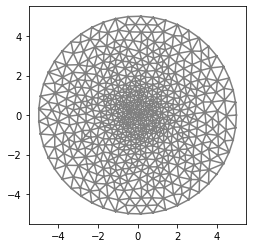

In [3]:
mesh = fn.Mesh('coax_geometry/geo_charge.xml')
subdomains = fn.MeshFunction("size_t", mesh, 'coax_geometry/geo_charge_physical_region.xml')
boundaries = fn.MeshFunction('size_t', mesh, 'coax_geometry/geo_charge_facet_region.xml')

plt.figure()
fn.plot(mesh)
plt.show()

## Make Function Spaces and Measures

In [4]:
dx = fn.Measure('dx', domain=mesh, subdomain_data=subdomains)
ds = fn.Measure('ds', domain=mesh, subdomain_data=boundaries)
V0 = fn.FunctionSpace(mesh, 'DG', 0)
V = fn.FunctionSpace(mesh, 'P', 2)

## Boundary Conditions
In this case there is only one boundary condition, which is that the potential is zero at the boundary.

In [5]:
outer_boundary = fn.DirichletBC(V, fn.Constant(0), boundaries, 4)
bcs = [outer_boundary]

## User Expressions

### Current Density

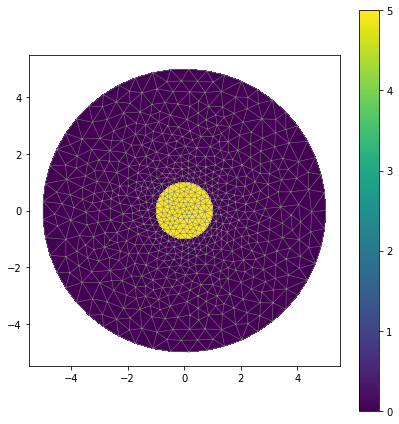

In [14]:
j = 5

class current_density(fn.UserExpression):
    def __init__(self, markers, **kwargs):
        self.markers = markers
        super().__init__(**kwargs)
        
    def eval_cell(self, values, x, cell):
        if self.markers[cell.index] == 1:
            values[0] = j
        else:
            values[0] = 0
    
        return 0

j_1 = current_density(subdomains, degree=1)

plt.figure(figsize=(6,6))
fn.plot(mesh, linewidth=0.5)
p = fn.plot(fn.project(j_1, V0))
plt.colorbar(p)
plt.tight_layout()
plt.show()

## Solve the Problem

In [15]:
5 * np.pi*1**2

15.707963267948966

In [8]:
fn.assemble(j_1*dx(1))

15.585356915299256

In [25]:
# Define variational problem
A_z = fn.TrialFunction(V)
v = fn.TestFunction(V)
a = fn.dot(fn.grad(A_z), fn.grad(v))*dx
L = mu_0  * (j_1*v*dx(1) + j_1*v*dx(2))

# Solve variational problem
A_z = fn.Function(V)
fn.solve(a == L, A_z, bcs)

# Compute magnetic field (B = curl A)
W = fn.VectorFunctionSpace(mesh, 'P', 1)
B = fn.project(fn.as_vector((A_z.dx(1), -A_z.dx(0))), W)


Calling FFC just-in-time (JIT) compiler, this may take some time.


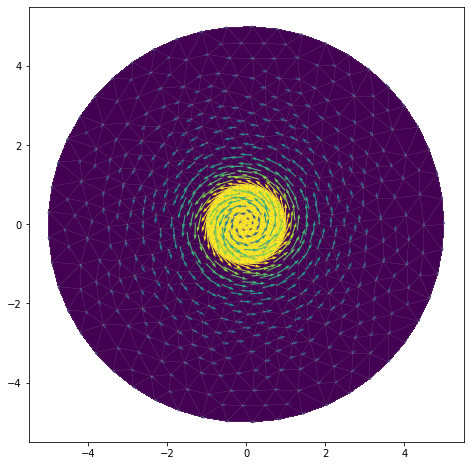

In [28]:
%matplotlib inline
plt.figure(figsize=(8,8))
fn.plot(fn.project(j_1, V0))
fn.plot(mesh, linewidth=0.2)
fn.plot(B)
plt.show()

## Comparison with Analytical Solution

In [23]:
def b(r, a, j):
    outside = np.abs(r) > a
    inside = np.logical_not(outside)
    b = np.zeros(len(r))
    b[inside] = mu_0 *j * r[inside] / 2
    b[outside] = mu_0 * j * a**2 / 2 / r[outside]
    return b

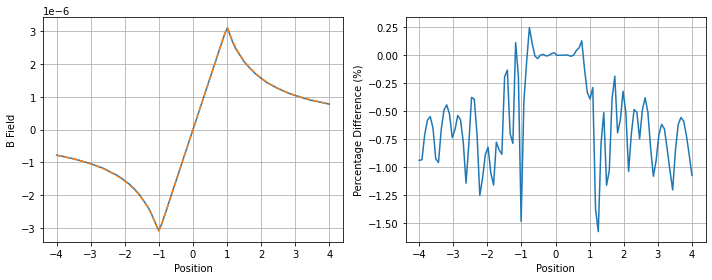

In [33]:
x = np.linspace(-4, 4, 100)
a = np.array(list(map(B, zip(x, np.zeros(len(x))))))

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(x, a[:, 1])
ax[0].plot(x, b(x, 1, j), '--')
ax[1].plot(x, (a[:, 1]-b(x, 1, j))/a[:, 1]*100)
ax[0].set_xlabel("Position")
ax[0].set_ylabel("B Field")

ax[1].set_xlabel("Position")
ax[1].set_ylabel("Percentage Difference (%)")

ax[0].grid()
ax[1].grid()
plt.tight_layout()
plt.show()